In [1]:
import h5py
import datetime
import numpy as np
import tensorflow as tf
from tensorflow import keras
from math import sqrt
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import cv2

import onnx
import tf2onnx

import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_model_optimization as tfmot
%matplotlib inline

2024-05-29 17:05:44.612708: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-05-29 17:05:44.612726: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
NUM_CLASSES = 8
IMG_SHAPE = (224, 224, 3)
BATCH_SIZE = 8

TRAIN_EPOCH = 1
TRAIN_LR = 1e-3
TRAIN_ES_PATIENCE = 5
TRAIN_LR_PATIENCE = 3
TRAIN_MIN_LR = 1e-6
TRAIN_DROPOUT = 0.1

# FT_EPOCH = 500
# FT_LR = 1e-5
# FT_LR_DECAY_STEP = 80.0
# FT_LR_DECAY_RATE = 1
# FT_ES_PATIENCE = 20
# FT_DROPOUT = 0.2

ES_LR_MIN_DELTA = 0.003

# Data Loading

In [3]:
def resize(pixel_string, image_size=(48, 48), target_size=(224, 224)):
    # convert string of pixels to image
    pixel_values = list(map(int, pixel_string.split()))
    image_array = np.array(pixel_values, dtype=np.uint8)
    image = image_array.reshape(image_size)
    # resize to target size
    resized_image = cv2.resize(image, target_size, interpolation=cv2.INTER_LINEAR)
    resized_image = cv2.cvtColor(resized_image, cv2.COLOR_GRAY2RGB)
    return resized_image

def load_data():
    x = pd.read_csv('datasets/ferplus.csv')
    x['Resized img'] = x['Pixels'].apply(resize)

    train_set = x[(x.Usage == 'Training')]
    validation_set = x[(x.Usage == 'PublicTest')]
    test_set = x[(x.Usage == 'PrivateTest')]

    X_train = train_set['Resized img']
    X_valid = validation_set['Resized img']
    X_test = test_set['Resized img']

    X_train = np.stack(X_train.values)
    X_valid = np.stack(X_valid.values)
    X_test = np.stack(X_test.values)

    y_train = train_set['Class int']
    y_valid = validation_set['Class int']
    y_test = test_set['Class int']

    return X_train, y_train, X_valid, y_valid, X_test, y_test

X_train, y_train, X_valid, y_valid, X_test, y_test = load_data()
X_train, y_train = shuffle(X_train, y_train)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
class_names = ['neutral', 'sadness', 'happiness', 'surprise', 'anger', 'fear', 'contempt', 'disgust']

In [4]:
X_train[0].shape
X_valid[0].shape

(224, 224, 3)

# Model Creation

In [15]:
############################################################
#
# ORIGINAL MODEL
#
#############################################################

def create_model():
    input_layer = tf.keras.Input(shape=(224, 224, 3), name='universal_input')

    # Resize as MobileNet requires 244x244 images
    # sample_resizing = tf.keras.layers.Resizing(224, 224, name="resize")

    # Flip and add contrast
    data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip(mode='horizontal'), 
                                            tf.keras.layers.RandomContrast(factor=0.3)], name="augmentation")
    # Data ranges from [-1, 1]
    preprocess_input = tf.keras.applications.mobilenet.preprocess_input
    # preprocess_input = keras.layers.Rescaling(scale=1./127.5, offset=-1.)    # between [-1, 1]

    backbone = tf.keras.applications.mobilenet.MobileNet(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    backbone.trainable = False
    base_model = tf.keras.Model(backbone.input, backbone.layers[-29].output, name='base_model')

    patch_extraction = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(256, kernel_size=4, strides=4, padding='same', activation='relu'), 
        tf.keras.layers.SeparableConv2D(256, kernel_size=2, strides=2, padding='valid', activation='relu'), 
        tf.keras.layers.Conv2D(256, kernel_size=1, strides=1, padding='valid', activation='relu')
    ], name='patch_extraction')

    global_average_layer = tf.keras.layers.GlobalAveragePooling2D(name='gap')

    custom_reduction = tf.keras.Sequential([
        tf.keras.layers.Conv2D(256, kernel_size=1, activation='relu'),  # Custom reduction layer
        tf.keras.layers.Flatten()  # Flatten to convert to 1D tensor
    ], name='custom_reduction')

    pre_classification = tf.keras.Sequential([tf.keras.layers.Dense(32, activation='relu'), 
                                            tf.keras.layers.BatchNormalization()], name='pre_classification')

    # prediction_layer = tf.keras.layers.Dense(8, activation='softmax', name='classification_head')
    classification_layer = tf.keras.layers.Dense(8, name='classification_head')

    # Perform all operations
    inputs = input_layer
    # x = sample_resizing(inputs)
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = patch_extraction(x)
    # x = global_average_layer(x)
    x = custom_reduction(x)
    x = tf.keras.layers.Dropout(TRAIN_DROPOUT)(x)
    x = pre_classification(x)
    # outputs = prediction_layer(x)
    x = classification_layer(x)
    outputs = tf.keras.activations.softmax(x)
    
    model = tf.keras.Model(inputs, outputs, name='train-head')

    return model

model = create_model()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=TRAIN_LR, global_clipnorm=3.0), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [54]:
# ######################################################
# #
# # QUANTIZED MODEL
# # 
# ######################################################

# def create_model():
#     input_layer = tf.keras.Input(shape=IMG_SHAPE, name='universal_input')

#     # Resize as MobileNet requires 244x244 images
#     sample_resizing = tf.keras.layers.Resizing(224, 224, name="resize")

#     # Flip and add contrast
#     random_flip_layer = tf.keras.layers.RandomFlip(mode='horizontal', name='random_flip')
#     random_contrast_layer = tf.keras.layers.RandomContrast(factor=0.3, name='random_contrast')

#     # Data ranges from [-1, 1]
#     preprocess_input = tf.keras.applications.mobilenet.preprocess_input

#     # Load MobileNet model
#     mobilenet = tf.keras.applications.MobileNet(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
#     mobilenet.trainable = False

#     # Define layers for patch extraction
#     separable_conv1 = tf.keras.layers.SeparableConv2D(256, kernel_size=4, strides=4, padding='same', activation='relu', name='separable_conv1')
#     separable_conv2 = tf.keras.layers.SeparableConv2D(256, kernel_size=2, strides=2, padding='valid', activation='relu', name='separable_conv2')
#     conv = tf.keras.layers.Conv2D(256, kernel_size=1, strides=1, padding='valid', activation='relu', name='conv')

#     # Define global average pooling layer
#     global_average_layer = tf.keras.layers.GlobalAveragePooling2D(name='gap')

#     # Define pre-classification layers
#     dense1 = tf.keras.layers.Dense(32, activation='relu', name='dense1')
#     batch_norm = tf.keras.layers.BatchNormalization(name='batchnorm_layer')

#     # Define prediction layer
#     prediction_layer = tf.keras.layers.Dense(10, activation="softmax", name='classification_head')

#     # Apply each layer sequentially
#     # inputs = mobilenet.input
#     inputs = input_layer
#     x = sample_resizing(inputs)
#     x = random_flip_layer(x)
#     x = random_contrast_layer(x)
#     x = preprocess_input(x)

#     for layer in mobilenet.layers[1:-28]:
#         x = tfmot.quantization.keras.quantize_annotate_layer(layer)(x)

#     # Patch extraction
#     x = tfmot.quantization.keras.quantize_annotate_layer(separable_conv1)(x)
#     x = tfmot.quantization.keras.quantize_annotate_layer(separable_conv2)(x)
#     x = tfmot.quantization.keras.quantize_annotate_layer(conv)(x)

#     # Global average pooling
#     x = tfmot.quantization.keras.quantize_annotate_layer(global_average_layer)(x)
#     x = tf.keras.layers.Dropout(TRAIN_DROPOUT)(x)

#     # Pre-classification
#     x = tfmot.quantization.keras.quantize_annotate_layer(dense1)(x)
#     x = batch_norm(x)

#     # Prediction
#     outputs = prediction_layer(x)

#     # # Define the model
#     base_model = tf.keras.Model(inputs=inputs, outputs=outputs, name='base_model')

#     return base_model

# quant_model = create_model()
# quant_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=TRAIN_LR, global_clipnorm=3.0), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # train model
# early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
#                                                            patience=TRAIN_ES_PATIENCE,  # how many epochs to wait before stopping
#                                                            min_delta=ES_LR_MIN_DELTA,   # minimium amount of change to count as an improvement
#                                                            restore_best_weights=True)

# learning_rate_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
#                                                               patience=TRAIN_LR_PATIENCE, 
#                                                               verbose=0, 
#                                                               min_delta=ES_LR_MIN_DELTA, 
#                                                               min_lr=TRAIN_MIN_LR)

# history = quant_model.fit(X_train, y_train, epochs=2, batch_size=BATCH_SIZE, validation_data=(X_valid, y_valid), verbose=0, 
#                     class_weight=class_weights, callbacks=[early_stopping_callback, learning_rate_callback])

# test_loss, test_acc = quant_model.evaluate(X_test, y_test)

# # apply quantization
# quantized_model = tfmot.quantization.keras.quantize_apply(quant_model)
# quantized_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=TRAIN_LR, global_clipnorm=3.0), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# quantized_model.summary()

# # train again
# quantized_model.fit(X_train[:1000], y_train[:1000], epochs=2, batch_size=BATCH_SIZE, validation_data=(X_valid[:100], y_valid[:100]), verbose=0, 
#                     class_weight=class_weights, callbacks=[early_stopping_callback, learning_rate_callback])

# # _, baseline_model_accuracy = model.evaluate(X_test, y_test, verbose=0)
# # print('Baseline test accuracy:', baseline_model_accuracy)
# _, q_aware_model_accuracy = quantized_model.evaluate(X_test, y_test, verbose=0)
# print('Quant test accuracy:', q_aware_model_accuracy)

# # convert ?
# converter = tf.lite.TFLiteConverter.from_keras_model(quantized_model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# quantized_tflite_model = converter.convert()
# quantized_tflite_model


In [16]:
model.summary()
# keras.utils.plot_model(model)

Model: "train-head"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 universal_input (InputLayer  [(None, 224, 224, 3)]    0         
 )                                                               
                                                                 
 augmentation (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 base_model (Functional)     (None, 14, 14, 512)       821952    
                                                        

In [17]:
def compute_model_size(model):
    total_size = 0

    for layer in model.layers:
        params = layer.get_weights()
        if params:
            for param in params:
                param_size = np.prod(param.shape) * param.dtype.itemsize
                total_size += param_size

    # Convert to megabytes
    total_size_mb = total_size / (1024 * 1024)
    return total_size_mb

model_size_mb = compute_model_size(model)
print("Model size: {:.2f} MB".format(model_size_mb))

Model size: 4.55 MB


# Training

In [18]:
# Training Procedure
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                           patience=TRAIN_ES_PATIENCE,  # how many epochs to wait before stopping
                                                           min_delta=ES_LR_MIN_DELTA,   # minimium amount of change to count as an improvement
                                                           restore_best_weights=True)

learning_rate_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                              patience=TRAIN_LR_PATIENCE, 
                                                              verbose=0, 
                                                              min_delta=ES_LR_MIN_DELTA, 
                                                              min_lr=TRAIN_MIN_LR)

history = model.fit(X_train, y_train, epochs=1, batch_size=BATCH_SIZE, validation_data=(X_valid, y_valid), verbose=0, 
                    class_weight=class_weights, callbacks=[early_stopping_callback, learning_rate_callback])

test_loss, test_acc = model.evaluate(X_test, y_test)

2024-05-29 17:24:22.040376: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 534825984 exceeds 10% of free system memory.


111/111 [==============================] - 40s 362ms/step - loss: 1.3234 - accuracy: 0.5130


# Evaluation

2024-05-29 17:13:15.481673: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 533772288 exceeds 10% of free system memory.


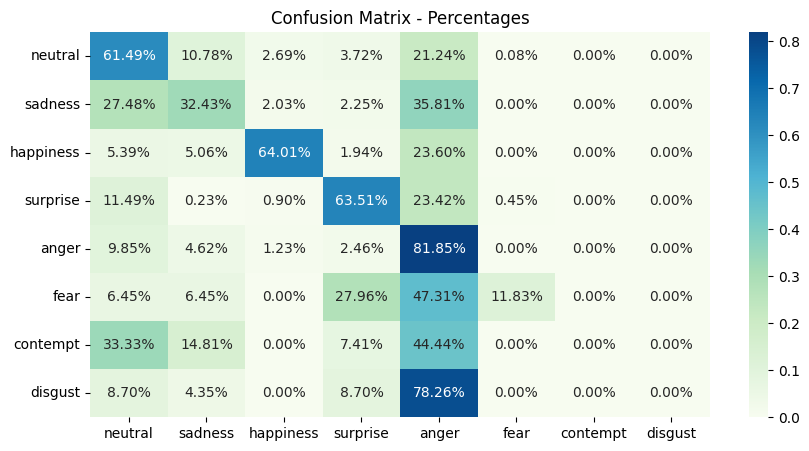

In [8]:
prediction = model.predict(X_test)
predicted_classes = np.argmax(prediction, axis=1)

cm_array = confusion_matrix(y_test, predicted_classes,
                            normalize='true')

cm_array_df = pd.DataFrame(cm_array, index=class_names, columns=class_names)

# Plot confusion matrix
plt.figure(figsize=(10,5))
plt.title("Confusion Matrix - Percentages")
sns.heatmap(cm_array_df, annot=True, fmt='.2%', cmap="GnBu")
plt.show()

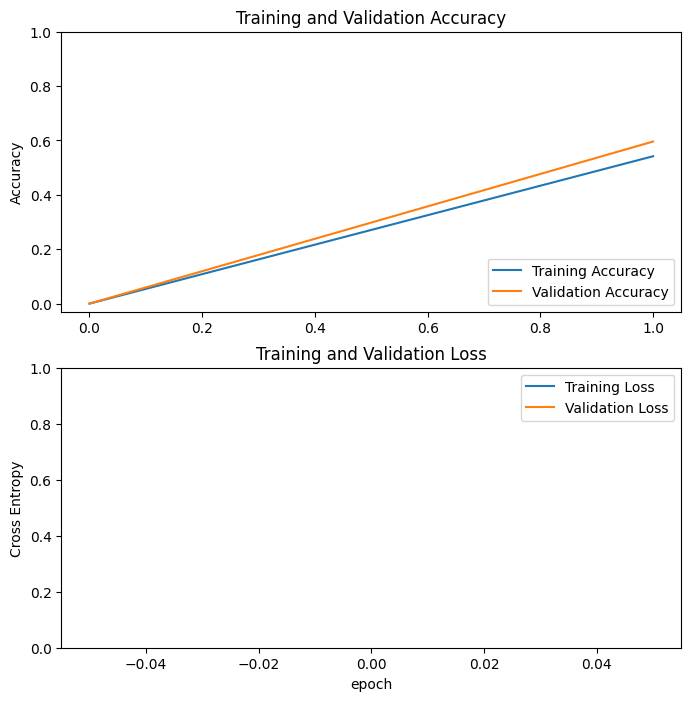

In [9]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Change Activation Function

In [19]:
input_layer = model.input
# The layer before the softmax
logits_layer = model.layers[-2].output
# New output layer with argmax
argmax_output = tf.keras.layers.Lambda(lambda x: tf.argmax(x, axis=-1), name='argmax')(logits_layer)
new_model = tf.keras.Model(inputs=input_layer, outputs=argmax_output)

prediction = new_model.predict(X_test)
accuracy = tf.reduce_mean(tf.cast(tf.equal(y_test, prediction), tf.float32))
print("Accuracy:", accuracy.numpy())

Accuracy: 0.51297235


# Saving Model

In [20]:
# input_signature = [tf.TensorSpec([None, 224, 224, 3], tf.float32, name='x')]
# onnx_model, _ = tf2onnx.convert.from_keras(new_model, input_signature, opset=13)
# onnx.save_model(onnx_model, 'model29may2.onnx')

2024-05-29 17:26:28.118564: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-29 17:26:28.118720: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-05-29 17:26:28.118783: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2024-05-29 17:26:28.119257: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-29 17:26:28.119412: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and 

In [ ]:
# model.save('Model.h5')
# model.save("Model.keras")

# Convert Shape Tensor of Initializers 

In [ ]:
# model = onnx.load("models/model29may2.onnx")

In [ ]:
# # print cases where the initializer has dimension []
# for idx, initializer in enumerate(testmodel.graph.initializer):
#     if initializer.dims == []:
#         print(f"Name: {initializer.name}, Shape: {initializer.dims}, Data type: {initializer.data_type}")
#         print(idx)

# print(testmodel.graph.initializer[1])
# print(testmodel.graph.initializer[40])
# print(testmodel.graph.initializer[41])
# print(testmodel.graph.initializer[57])

# print(testmodel.graph.initializer[1])
# print(testmodel.graph.initializer[2])
# print(testmodel.graph.initializer[17])
# print(testmodel.graph.initializer[52])

# # rewrite manually
# numpy_array = np.array([1], dtype=float)
# tensor = onnx.numpy_helper.from_array(numpy_array, name="model_1/tf.math.subtract/Sub/y:0")
# testmodel.graph.initializer[1].CopyFrom(tensor)

# numpy_array2 = np.array([0.007843137718737125], dtype=float)
# tensor2 = onnx.numpy_helper.from_array(numpy_array2, name="ConstantFolding/model_1/tf.math.truediv/truediv_recip:0")
# testmodel.graph.initializer[57].CopyFrom(tensor2)

# # to check
# for idx, initializer in enumerate(testmodel.graph.initializer):
#     print(f"Name: {initializer.name}, Shape: {initializer.dims}, Data type: {initializer.data_type}")

# # save model
# onnx.save_model(testmodel, 'model29may2.onnx')
